# Step 0 - Data Exploration and Preparation

## Overview

Our goal is to train a deep learning model that can make steering angle predictions based on an input that comprises of camera images and the vehicle's last known state. In this notebook, we will prepare the data for our end-to-end deep learning model. Along the way, we will also make some useful observations about the dataset that will aid us when it comes time to train the model. 


## What is end-to-end deep learning?

End-to-end deep learning is a modeling strategy that is a response to the success of deep neural networks. Unlike traditional methods, this strategy is not built on feature engineering. Instead, it leverages the power of deep neural networks, along with recent hardware advances (GPUs, FPGAs etc.) to harness the incredible potential of large amounts of data. It is closer to a human-like learning approach than traditional ML as it lets a neural network map raw input to direct output. A big downside to this approach is that it requires a very large amount of training data which makes it unsuitable for many common applications. Since simulators can (potentially) generate data in infinite amounts, they are a perfect data source for end-to-end deep learning algorithms. If you wish to learn more, [this video](https://www.coursera.org/learn/machine-learning-projects/lecture/k0Klk/what-is-end-to-end-deep-learning) by Andrew Ng provides a nice overview of the topic.

Autonomous driving is a field that can highly benefit from the power of end-to-end deep learning. In order to achieve SAE Level 4 or 5 Autonomy, cars need to be trained on copious amounts of data (it is not uncommon for car manufacturers to collect hundreds of petabytes of data every week), something that is virtually impossible without a simulator. 

With photo-realistic simulators like [AirSim](https://github.com/Microsoft/AirSim), it is now possible to collect a large amount of data to train your autonomous driving models without having to use an actual car. These models can then be fine tuned using a comparably lesser amount of real-world data and used on actual cars. This technique is called Behavioral Cloning. In this tutorial, you will train a model to learn how to steer a car through a portion of the Landscape map in AirSim using only one of the front facing webcams on the car as visual input. Our strategy will be to perform some basic data analysis to get a feel for the dataset, and then train an end-to-end deep learning model to predict the correct driving control signal (in this case the steering angle) given a frame from the webcam, and the car's current state parameters (speed, steering angle, throttle etc.).

Before you begin, please make sure you have the dataset for the tutorial downloaded. If you missed the instructions in the readme file, [you can download the dataset from here](https://aka.ms/AirSimTutorialDataset).

Let us start by importing some standard libraries.

**NOTE: If you see text within << ...... >> in some of the comments in these notebooks, it means you are expected to make a change in the accompanying code.**

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import os
import Cooking
import random

# << Point this to the directory containing the raw data >>
RAW_DATA_DIR = 'data_raw/'

# << Point this to the desired output directory for the cooked (.h5) data >>
COOKED_DATA_DIR = 'data_cooked/'

# The folders to search for data under RAW_DATA_DIR
# For example, the first folder searched will be RAW_DATA_DIR/normal_1
DATA_FOLDERS = ['normal_1', 'normal_2', 'normal_3', 'normal_4', 'normal_5', 'normal_6', 'swerve_1', 'swerve_2', 'swerve_3']

# The size of the figures in this notebook
FIGURE_SIZE = (10,10)

Let's take a look at the raw data. There are two parts to the dataset - the images and the .tsv file. First, let us read one of the .tsv files.

In [2]:
sample_tsv_path = os.path.join(RAW_DATA_DIR, 'normal_1/airsim_rec.txt')
sample_tsv = pd.read_csv(sample_tsv_path, sep='\t')
sample_tsv.head()

,Timestamp,Speed (kmph),Throttle,Steering,Brake,Gear,ImageName
0,93683464,0,0.0,0.000000,0.0,N,img_0.png
1,93689595,0,0.0,0.000000,0.0,N,img_1.png
2,93689624,0,0.0,-0.035522,0.0,N,img_2.png
3,93689624,0,0.0,-0.035522,0.0,N,img_3.png
4,93689624,0,0.0,-0.035522,0.0,N,img_4.png


This dataset contains our label, the steering angle. It also has the name of the image taken at the time the steering angle was recorded. Let's look at a sample image - 'img_0.png' inside the 'normal_1' folder (more on our folder naming style later).

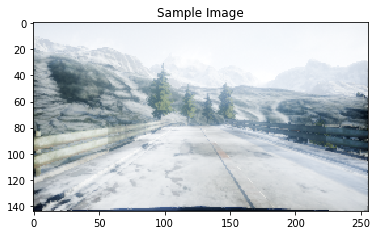

In [3]:
sample_image_path = os.path.join(RAW_DATA_DIR, 'normal_1/images/img_0.png')
sample_image = Image.open(sample_image_path)
plt.title('Sample Image')
plt.imshow(sample_image)
plt.show()

One immediate observation that we can make about this image is that **only a small portion of the image is of interest**. For example, we should be able to determine how to steer the car by just focusing on the ROI of the image shown in red below

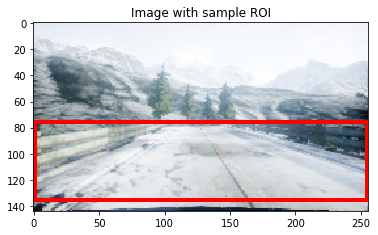

In [4]:
sample_image_roi = sample_image.copy()

fillcolor=(255,0,0)
draw = ImageDraw.Draw(sample_image_roi)
points = [(1,76), (1,135), (255,135), (255,76)]
for i in range(0, len(points), 1):
    draw.line([points[i], points[(i+1)%len(points)]], fill=fillcolor, width=3)
del draw

plt.title('Image with sample ROI')
plt.imshow(sample_image_roi)
plt.show()

**Extracting this ROI will both reduce the training time and the amount of data needed to train the model**. It will also prevent the model from getting confused by focusing on irrelevant features in the environment (e.g. mountains, trees, etc)

Another observation we can make is that **the dataset exhibits a vertical flip tolerance**. That is, we get a valid data point if we flip the image around the Y axis if we also flip the sign of the steering angle. This is important as it effectively doubles the number of data points we have available. 

Additionally, **the trained model should be invariant to changes in lighting conditions**, so we can generate additional data points by globally scaling the brightness of the image.


> **Thought Exercise 0.1:** 
Once you are finished with the tutorial, as an exercise, you should try working with the dataset provided without modifying it using one or more of the 3 changes described above, keeping everything else the same. Do you experience vastly different results? 



> **Thought Exercise 0.2:**
We mentioned in the Readme that end-to-end deep learning eliminates the need for manual feature engineering before feeding the data to the learning algorithm. Would you consider making these pre-processing changes to the dataset as engineered features? Why or why not? 


Now, let's aggregate all the non-image data into a single dataframe to get some more insights.

In [5]:
full_path_raw_folders = [os.path.join(RAW_DATA_DIR, f) for f in DATA_FOLDERS]

dataframes = []
for folder in full_path_raw_folders:
    current_dataframe = pd.read_csv(os.path.join(folder, 'airsim_rec.txt'), sep='\t')
    current_dataframe['Folder'] = folder
    dataframes.append(current_dataframe)
    
dataset = pd.concat(dataframes, axis=0)

print('Number of data points: {0}'.format(dataset.shape[0]))

dataset.head()

Number of data points: 46738


,Timestamp,Speed (kmph),Throttle,Steering,Brake,Gear,ImageName,Folder
0,93683464,0,0.0,0.000000,0.0,N,img_0.png,data_raw/normal_1
1,93689595,0,0.0,0.000000,0.0,N,img_1.png,data_raw/normal_1
2,93689624,0,0.0,-0.035522,0.0,N,img_2.png,data_raw/normal_1
3,93689624,0,0.0,-0.035522,0.0,N,img_3.png,data_raw/normal_1
4,93689624,0,0.0,-0.035522,0.0,N,img_4.png,data_raw/normal_1


Let us now address the naming of the dataset folders. You will notice that we have two types of folders in our dataset - 'normal', and 'swerve'. These names refer to two different driving strategies. Let's begin by attempting to get an understanding of the differences between these two styles of driving. First, we'll plot a portion of datapoints from each of the driving styles against each other.

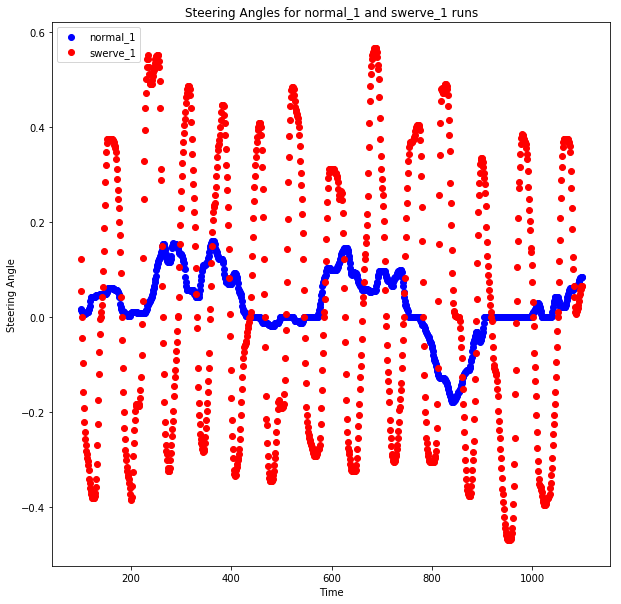

In [6]:
min_index = 100
max_index = 1100
steering_angles_normal_1 = dataset[dataset['Folder'].apply(lambda v: 'normal_1' in v)]['Steering'][min_index:max_index]
steering_angles_swerve_1 = dataset[dataset['Folder'].apply(lambda v: 'swerve_1' in v)]['Steering'][min_index:max_index]

plot_index = [i for i in range(min_index, max_index, 1)]

fig = plt.figure(figsize=FIGURE_SIZE)
ax1 = fig.add_subplot(111)

ax1.scatter(plot_index, steering_angles_normal_1, c='b', marker='o', label='normal_1')
ax1.scatter(plot_index, steering_angles_swerve_1, c='r', marker='o', label='swerve_1')
plt.legend(loc='upper left');
plt.title('Steering Angles for normal_1 and swerve_1 runs')
plt.xlabel('Time')
plt.ylabel('Steering Angle')
plt.show()

We can observe a clear difference between the two driving strategies here. The blue points show the normal driving strategy, which as you would expect, keeps your steering angle close to zero more or less, which makes your car mostly go straight on the road. 

The swerving driving strategy has the car almost oscillating side to side across the road. This illustrates a very important thing to keep in mind while training end-to-end deep learning models. Since we are not doing any feature engineering, our model relies almost entirely on the dataset to provide it with all the necessary information it would need during recall. Hence, to account for any sharp turns the model might encounter, and to give it the ability to correct itself if it starts to go off the road, we need to provide it with enough such examples while training. Hence, we created these extra datasets to focus on those scenarios. Once you are done with the tutorial, you can try re-running everything using only the 'normal' dataset and watch your car fail to keep on the road for an extended period of time.

> **Thought Exercise 0.3:**
What other such data collection techniques do you think might be necessary for this steering angle prediction scenario? What about autonomous driving in general?

Now, let us take a look at the number of datapoints in each category.

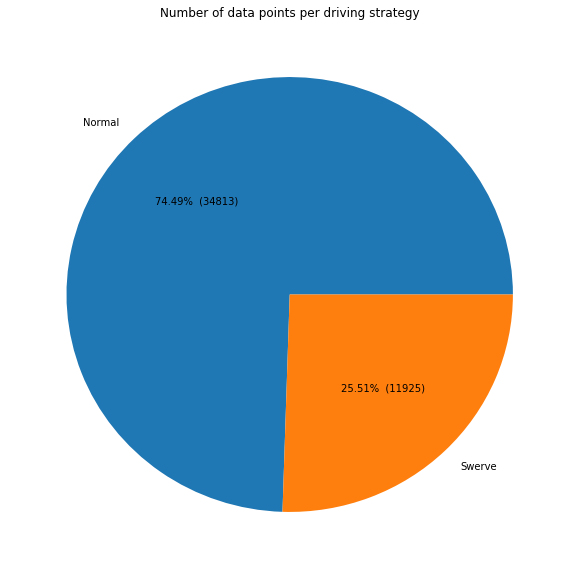

In [7]:
dataset['Is Swerve'] = dataset.apply(lambda r: 'swerve' in r['Folder'], axis=1)
grouped = dataset.groupby(by=['Is Swerve']).size().reset_index()
grouped.columns = ['Is Swerve', 'Count']

def make_autopct(values):
    def my_autopct(percent):
        total = sum(values)
        val = int(round(percent*total/100.0))
        return '{0:.2f}%  ({1:d})'.format(percent,val)
    return my_autopct

pie_labels = ['Normal', 'Swerve']
fig, ax = plt.subplots(figsize=FIGURE_SIZE)
ax.pie(grouped['Count'], labels=pie_labels, autopct = make_autopct(grouped['Count']))
plt.title('Number of data points per driving strategy')
plt.show()

So, roughly a quarter of the data points are collected with the swerving driving strategy, and the rest are collected with the normal strategy. We also see that we have almost 47,000 data points to work with. This is nearly not enough data, hence our network cannot be too deep. 

> **Thought Exercise 0.4:**
Like many things in the field of Machine Learning, the ideal ratio of number of datapoints in each category here is something that is problem specific, and can only be optimized by trial and error. Can you find a split that works better than ours?

Let's see what the distribution of labels looks like for the two strategies.

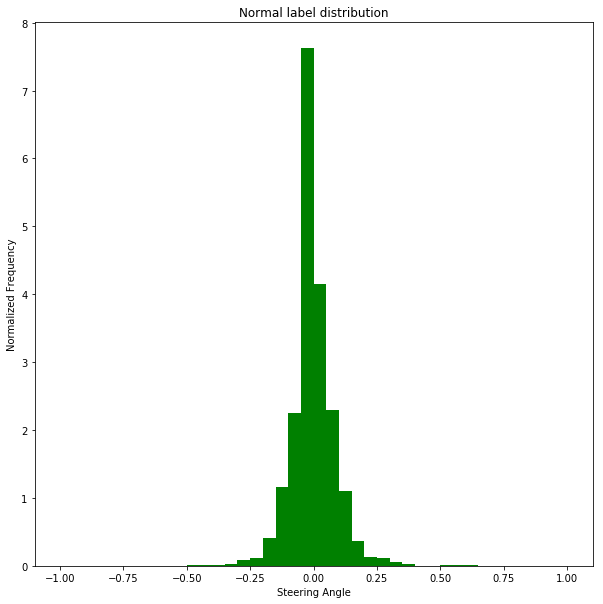

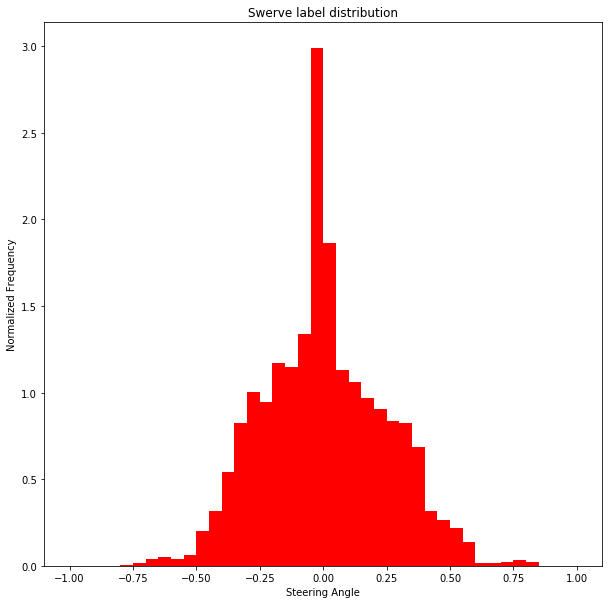

In [8]:
bins = np.arange(-1, 1.05, 0.05)
normal_labels = dataset[dataset['Is Swerve'] == False]['Steering']
swerve_labels = dataset[dataset['Is Swerve'] == True]['Steering']

def steering_histogram(hist_labels, title, color):
    plt.figure(figsize=FIGURE_SIZE)
    n, b, p = plt.hist(hist_labels.as_matrix(), bins, normed=1, facecolor=color)
    plt.xlabel('Steering Angle')
    plt.ylabel('Normalized Frequency')
    plt.title(title)
    plt.show()

steering_histogram(normal_labels, 'Normal label distribution', 'g')
steering_histogram(swerve_labels, 'Swerve label distribution', 'r')


There are a few observations we can make about the data from these plots:
* **When driving the car normally, the steering angle is almost always zero**. There is a heavy imbalance and if this portion of the data is not downsampled, the model will always predict zero, and the car will not be able to turn.
* When driving the car with the swerve strategy, we get examples of sharp turns that don't appear in the normal strategy dataset. **This validates our reasoning behind collecting this data as explained above.** 

At this point, we need to combine the raw data into compressed data files suitable for training. Here, we will use .h5 files, as this format is ideal for supporting large datasets without reading everything into memory all at once. It also works seamlessly with Keras.

The code for cooking the dataset is straightforward, but long. When it terminates, the final dataset will have 4 parts:

* **image**: a numpy array containing the image data
* **previous_state**: a numpy array containing the last known state of the car. This is a (steering, throttle, brake, speed) tuple
* **label**: a numpy array containing the steering angles that we wish to predict (normalized on the range -1..1)
* **metadata**: a numpy array containing metadata about the files (which folder they came from, etc)

The processing may take some time. We will also combine all the datasets into one and then split it into train/test/validation datasets.

In [9]:
train_eval_test_split = [0.7, 0.2, 0.1]
full_path_raw_folders = [os.path.join(RAW_DATA_DIR, f) for f in DATA_FOLDERS]
Cooking.cook(full_path_raw_folders, COOKED_DATA_DIR, train_eval_test_split)

Reading data from data_raw/normal_1...
Reading data from data_raw/normal_2...
Reading data from data_raw/normal_3...
Reading data from data_raw/normal_4...
Reading data from data_raw/normal_5...
Reading data from data_raw/normal_6...
Reading data from data_raw/swerve_1...
Reading data from data_raw/swerve_2...
Reading data from data_raw/swerve_3...
Processing data_cooked/train.h5...
Finished saving data_cooked/train.h5.
Processing data_cooked/eval.h5...
Finished saving data_cooked/eval.h5.
Processing data_cooked/test.h5...
Finished saving data_cooked/test.h5.


We are now ready to start building our model. Head over to the [next notebook](TrainModel.ipynb) to begin.